# TimeSHAP

#### Import

In [1]:
import numpy as np
import pandas as pd
from typing import Callable, Union
from timeshap.explainer.kernel import TimeShapKernel

from Load_and_Preprocess_Aachen import preprocess_aachen_dataset
from LSTM_Model_Training import load_model_structure_and_weights, plot_predictions_vs_actual, plot_residuals

import plotly.graph_objects as go
from plotly.subplots import make_subplots


import altair as alt
import copy

#### Variables

In [2]:
# Define the file path for the dataset
file_path = '/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/Aachen/Degradation_Prediction_Dataset_ISEA.mat'

# Define the number of test cells to be used
test_cell_count = 3

# Set the global random seed for reproducibility
random_state = 52
np.random.seed(random_state)


## Loading and Preprocessing Data

In [3]:
# Load and preprocess Aachen data
preprocessed_full = preprocess_aachen_dataset(
    file_path,
    test_cell_count=3,
    random_state=random_state,
    phase=None,
    log_transform=False
)

# Assign feature splits to LSTM-specific variables
X_train_lstm = preprocessed_full["X_train"]
X_val_lstm   = preprocessed_full["X_val"]
X_test_lstm  = preprocessed_full["X_test"]

# Also extract the target variables
y_train_norm = preprocessed_full["y_train"]
y_val_norm   = preprocessed_full["y_val"]
y_test_norm  = preprocessed_full["y_test"]

# Assign the y_max value
y_max = preprocessed_full["y_max"]

# Print the shapes to verify the assignments
print("  X_train_lstm:", X_train_lstm.shape)
print("  X_val_lstm:  ", X_val_lstm.shape)
print("  X_test_lstm: ", X_test_lstm.shape)
print("  y_train:", y_train_norm.shape)
print("  y_val:  ", y_val_norm.shape)
print("  y_test: ", y_test_norm.shape)

  X_train_lstm: (7190, 272, 1)
  X_val_lstm:   (1798, 272, 1)
  X_test_lstm:  (595, 272, 1)
  y_train: (7190,)
  y_val:   (1798,)
  y_test:  (595,)


## Load model

In [4]:
# Load the model structure and weights from the specified file
model = load_model_structure_and_weights('model_20250131_123220')

# Display the model summary to verify the structure and loaded weights
model

Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250131_123220.structure.json
Weights file: Aachen/Models/model_20250131_123220.weights.h5
Contents of directory 'Aachen/Models':
['model_20250127_135003.structure.json', 'model_20250131_124416.weights.h5', 'model_20250127_135003.weights.h5', 'model_20250128_130021.structure.json', 'model_20250128_130021.weights.h5', 'model_20250131_123220.structure.json', 'model_20250131_124416.structure.json', 'model_20250131_123220.weights.h5']
Model loaded from Aachen/Models/model_20250131_123220.structure.json and Aachen/Models/model_20250131_123220.weights.h5


<Sequential name=sequential_1, built=True>

## Test model

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5791e-04 - mae: 0.0192

Test Loss: 0.0011460963869467378
Test MAE: 0.027306677773594856
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
   Actual RUL80  Predicted RUL80
0        1060.0      1031.006592
1        1055.0      1031.462646
2        1050.0      1029.203613
3        1045.0      1024.487549
4        1040.0      1017.905579


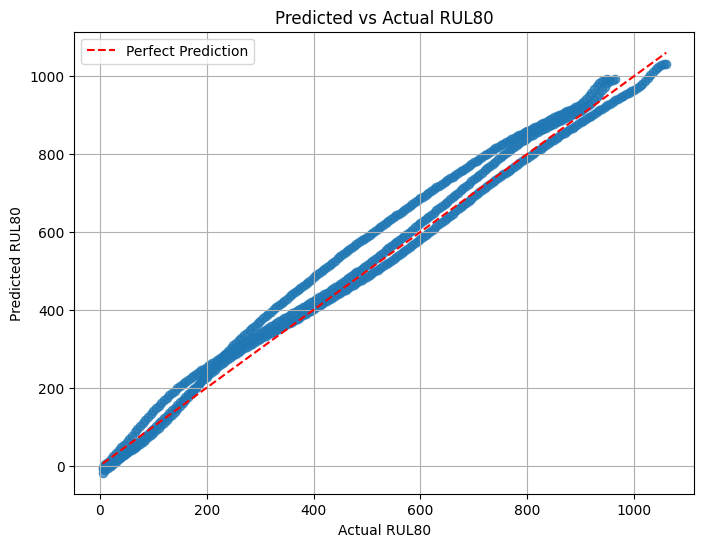

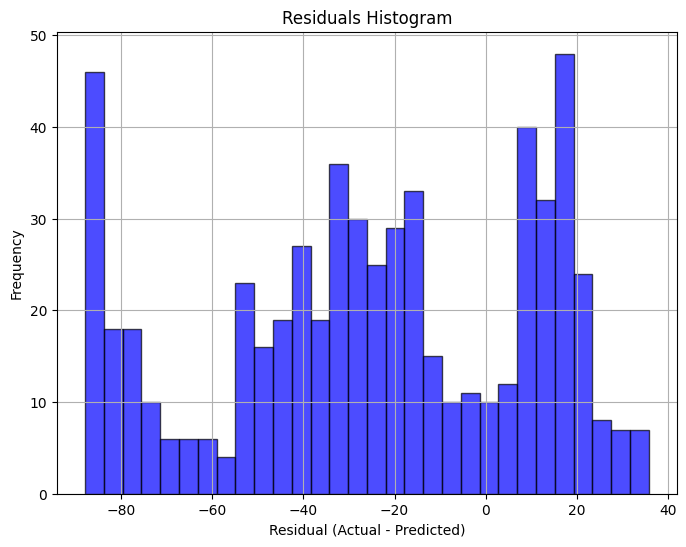

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,805 (135.96 KB)

 Trainable params: 11,601 (45.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,204 (90.64 KB)

None


In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test_norm, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test_norm * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)

# Plot residuals
plot_residuals(y_test_rescaled, y_pred_rescaled)

# Print model summary
print(model.summary())

AttributeError: 'numpy.ndarray' object has no attribute 'type'

### Model tests on trimmed data

In [56]:
def evaluate_model_on_trimmed_sequences(model, X_test):
    """
    Evaluates the model on each trimmed sequence from X_test.
    
    Parameters
    ----------
    model : callable
        The model to be evaluated. It should accept a 3-D numpy array of shape (1, seq_len, 1)
        and return a 2-D numpy array (for example, predictions).
    X_test : np.ndarray
        Test sequences with shape (n_samples, seq_len, 1). These sequences are assumed to be padded
        (e.g., with zeros) to a fixed length.
    
    Returns
    -------
    list
        A list of model predictions, one for each trimmed sequence.
    """
    predictions = []
    for i, seq in enumerate(X_test):
        # Compute a mask for the current sequence: True for timesteps where not all features are zero.
        mask = ~np.all(seq == 0, axis=-1)
        # Trim the sequence using the mask.
        trimmed_seq = seq[mask, :]
        # Add the batch dimension so that the sequence has shape (1, trimmed_seq_len, 1)
        trimmed_seq = trimmed_seq[np.newaxis, :, :]
        
        # Evaluate the model on the trimmed sequence.
        pred = model(trimmed_seq)
        predictions.append(pred)
        
        # Optionally print the shape for debugging.
        print(f"Sequence {i}: original length = {seq.shape[0]}, trimmed length = {trimmed_seq.shape[1]}")
    
    # Convert the list of predictions to a numpy array.
    predictions = np.array(predictions).squeeze()  # Remove the batch dimension.
    return predictions

Sequence 0: original length = 272, trimmed length = 21
Sequence 1: original length = 272, trimmed length = 22
Sequence 2: original length = 272, trimmed length = 23
Sequence 3: original length = 272, trimmed length = 24
Sequence 4: original length = 272, trimmed length = 25
Sequence 5: original length = 272, trimmed length = 26
Sequence 6: original length = 272, trimmed length = 27
Sequence 7: original length = 272, trimmed length = 28
Sequence 8: original length = 272, trimmed length = 29
Sequence 9: original length = 272, trimmed length = 30
Sequence 10: original length = 272, trimmed length = 31
Sequence 11: original length = 272, trimmed length = 32
Sequence 12: original length = 272, trimmed length = 33
Sequence 13: original length = 272, trimmed length = 34
Sequence 14: original length = 272, trimmed length = 35
Sequence 15: original length = 272, trimmed length = 36
Sequence 16: original length = 272, trimmed length = 37
Sequence 17: original length = 272, trimmed length = 38
Se

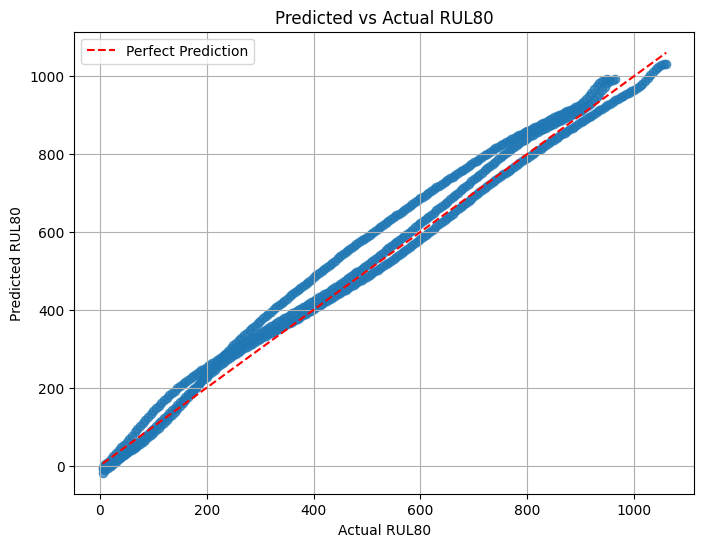

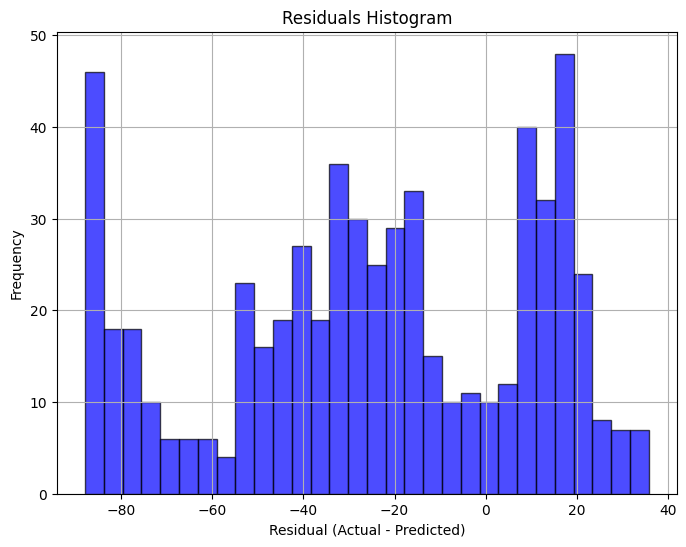

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,805 (135.96 KB)

 Trainable params: 11,601 (45.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,204 (90.64 KB)

None


In [ ]:
# Make predictions on the test set
y_pred_trimmed = evaluate_model_on_trimmed_sequences(model, X_test_lstm)


# Rescale predictions and test data back to the original range
y_pred_trimmed_rescaled = y_pred_trimmed.flatten() * y_max
y_test_rescaled = y_test_norm * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_trimmed_rescaled
})
print(results.head())

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_trimmed_rescaled)

# Plot residuals
plot_residuals(y_test_rescaled, y_pred_trimmed_rescaled)

# Print model summary
print(model.summary())

In [58]:
# Plot the difference between the original and trimmed predictions

# Compute the difference between the original and trimmed predictions
diff = y_pred_rescaled - y_pred_trimmed_rescaled

# Plot the difference
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(diff)), y=diff, mode="markers"))
fig.update_layout(
    title="Difference Between Original and Trimmed Predictions",
    xaxis_title="Sequence Index",
    yaxis_title="Difference",
    showlegend=False
)
fig.show()

## TimeSHAP

### Model entry point

In [6]:
# Define the model prediction function
f = lambda x: model.predict(x)

### Baseline event

In [7]:
def avg_rul(X_train_lstm):
    # Reshape the array to 2D for easier processing
    X_train_lstm_2d = X_train_lstm.reshape(-1, X_train_lstm.shape[-1])
    
    # Create a mask to exclude rows that are all zeros
    non_zero_mask = np.any(X_train_lstm_2d != 0, axis=1)
    
    # Calculate the mean of the non-zero rows
    avg = np.mean(X_train_lstm_2d[non_zero_mask])
    
    # Return the average as a NumPy array with shape (1, 1)
    return np.array([[avg]])

average_event = avg_rul(X_train_lstm)

average_event

array([[0.6724684]], dtype=float32)

### Local explanations

#### Helper functions

In [34]:
def get_random_sequence(X_test):
    """
    Select a random sequence from the test set without trimming any timesteps.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test set with shape [n_samples, seq_len, n_features].
    
    Returns
    -------
    np.ndarray
        A random sequence with shape [1, seq_len, n_features].
    """
    random_index = np.random.randint(0, len(X_test))
    # Select a random sequence and add a batch dimension (resulting shape: [1, seq_len, n_features])
    random_sequence = X_test[random_index][np.newaxis, :, :]
    
    print("Random index:", random_index)
    print("Random sequence shape:", random_sequence.shape)
    return random_sequence

In [8]:
def get_random_trimmed_sequence(X_test):
    """
    Select a random sequence from the test set and trim out all timesteps
    that are entirely zeros.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test set with shape [n_samples, seq_len, n_features].
    
    Returns
    -------
    np.ndarray
        A trimmed sequence with shape [1, x, n_features], where x is the number
        of non-zero timesteps.
    """
    random_index = np.random.randint(0, len(X_test))
    # Select a random sequence and add a batch dimension (shape: [1, seq_len, n_features])
    random_sequence = X_test[random_index][np.newaxis, :, :]
    
    # Create a mask for timesteps that are not all zeros (for the first and only sample)
    mask = ~np.all(random_sequence[0] == 0, axis=-1)
    
    # Apply the mask along the time axis
    trimmed_sequence = random_sequence[:, mask, :]
    
    print("Random index:", random_index)
    print("Trimmed sequence shape:", trimmed_sequence.shape)
    return trimmed_sequence

In [ ]:
def create_dual_axis_explanation_plot(X_test, f, event_dict, baseline, pruned_idx=0):
    """
    Generates a dual-axis plot for a random trimmed sequence from the test set.
    One y-axis shows the Shapley values from the event-level explanation, and
    the other shows the corresponding sequence values.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test set with shape [n_samples, seq_len, n_features].
    f : Callable[[np.ndarray], np.ndarray]
        The model function to be explained.
    event_dict : dict
        Dictionary of event configuration parameters.
    baseline : Union[pd.DataFrame, np.ndarray]
        The baseline event for the explanation.
    pruned_idx : int, optional
        The index at which the sequence is pruned (default is 0).
    
    Returns
    -------
    plotly.graph_objects.Figure
        A dual-axis plot figure showing Shapley values and sequence values.
    """
    # Get a random trimmed sequence
    trimmed_sequence = get_random_trimmed_sequence(X_test)
    
    # Compute the event-level explanation using your function
    event_explanation = local_event_level_single_feature_standalone(
        f=f,
        data=trimmed_sequence,
        event_dict=event_dict,
        baseline=baseline,
        pruned_idx=pruned_idx
    )
    
    # Extract numeric event number from the "Event" column (e.g., "Event 3" -> 3)
    event_explanation['Event Number'] = event_explanation['Event'].str.extract(r'Event (\d+)').astype(int)
    
    # Get the sequence values (flattened from shape [1, x, 1] to [x])
    sequence_line = trimmed_sequence.flatten()
    
    # Create a dual y-axis plot using Plotly
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add Shapley Value trace on the primary y-axis.
    fig.add_trace(
        go.Scatter(
            x=event_explanation["Event Number"],
            y=event_explanation["Shapley Value"],
            mode='lines',
            name='Shapley Value'
        ),
        secondary_y=False
    )
    
    # Add Sequence Values trace on the secondary y-axis.
    fig.add_trace(
        go.Scatter(
            x=event_explanation["Event Number"],
            y=sequence_line,
            mode='lines',
            name='Sequence Values'
        ),
        secondary_y=True
    )
    
    # Update layout and y-axes titles.
    fig.update_layout(
        title="Event-level Explanation with Dual Y-Axis",
        xaxis_title="Event Number"
    )
    fig.update_yaxes(title_text="Shapley Value", secondary_y=False)
    fig.update_yaxes(title_text="Sequence Value", secondary_y=True)
    
    return fig

### Local Event-Level Explanation

In [41]:
def local_event_level_single_feature_standalone(
    f: Callable[[np.ndarray], np.ndarray],
    data: Union[pd.DataFrame, np.ndarray],
    event_dict: dict,
    baseline: Union[pd.DataFrame, np.ndarray],
    pruned_idx: int
) -> pd.DataFrame:
    """
    Computes event-level (cell-level) explanations for a single-feature model using
    the easier-to-use event mode of TimeShapKernel.
    
    Each time step (after the pruned index) is treated as an event.
    
    Parameters
    ----------
    f : Callable[[np.ndarray], np.ndarray]
        Model function that accepts a 3-D numpy array of shape (1, seq_len, 1)
        and returns a 2-D numpy array.
    data : Union[pd.DataFrame, np.ndarray]
        Input instance to be explained. If a DataFrame, it will be converted to a
        3-D numpy array.
    event_dict : dict
        Dictionary with parameters for the event explanation. Expected keys include:
          - 'rs': random seed (default: 42)
          - 'nsamples': number of samples for the kernel estimation (default: 1000)
    baseline : Union[pd.DataFrame, np.ndarray]
        Baseline data (e.g. an average event) used for integrating out features.
    pruned_idx : int
        The index at which the sequence is pruned (e.g. 0 if no pruning is applied).
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Event', 'Shapley Value'] listing the explanation
        for each event (time step).
    """
    # Convert DataFrame to numpy array if needed.
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
        # If 2-D, expand to 3-D (1, seq_len, num_features)
        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)
        # Ensure that the last dimension is 1 (since we have one feature)
        if data.shape[-1] != 1:
            data = data[..., np.newaxis]
    
    # Extract parameters for the explainer from event_dict.
    random_seed = event_dict.get('rs', 42)
    nsamples = event_dict.get('nsamples', 1000)
    
    # Instantiate the TimeShapKernel in event mode.
    # In event mode, the kernel automatically uses all time steps (after pruned_idx)
    # as the events to be explained.
    explainer = TimeShapKernel(f, baseline, random_seed, mode="event")
    
    # Compute Shapley values for the instance.
    # The output is an array of one value per event.
    shap_values_arr = explainer.shap_values(data, pruning_idx=pruned_idx, nsamples=nsamples)
    
    # In event mode, internally the explainer computes:
    #     self.varyingInds = np.arange(data.shape[1]-1, pruned_idx-1, -1)
    # so that the first computed value corresponds to the last time step.
    # To list events in natural order (from first event to last), we reverse the array.
    shap_values_arr_reversed = shap_values_arr[::-1]
    
    # Create labels for events.
    # Events correspond to the time steps starting at pruned_idx up to the end of the sequence.
    events = [f"Event {i}" for i in range(pruned_idx, data.shape[1])]
    
    # Build the explanation DataFrame.
    explanation_df = pd.DataFrame({
        "Event": events,
        "Shapley Value": shap_values_arr_reversed
    })
    
    return explanation_df

In [42]:
# Minimal event configuration.
event_dict = {
    'rs': random_state,          # Random seed.
    'nsamples': 10000    # Number of samples for the kernel estimation.
}

pruned_idx = 0  # No pruning in this simple example.

# Get the event-level explanation for 5 random sequences.

for i in range(5):
    fig = create_dual_axis_explanation_plot(X_test_lstm, f, event_dict, average_event, pruned_idx)
    fig.show()

Random index: 23
Random sequence shape: (1, 272, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


Random index: 277
Random sequence shape: (1, 272, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


Random index: 277
Random sequence shape: (1, 272, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


Random index: 277
Random sequence shape: (1, 272, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


Random index: 277
Random sequence shape: (1, 272, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [12]:
def aggregate_event_shapley_values(X_test, f, event_dict, baseline, pruned_idx=0, sample_size=5):
    """
    Runs the local_event_level_single_feature_standalone function over a sample of sequences
    and aggregates the Shapley values for each event index.
    
    Parameters
    ----------
    X_test : np.ndarray
        The test set (each element should have shape [seq_len, 1]).
    f : Callable[[np.ndarray], np.ndarray]
        The model function.
    event_dict : dict
        Dictionary with configuration parameters (e.g., random seed and nsamples).
    baseline : Union[pd.DataFrame, np.ndarray]
        Baseline data for the explainer.
    pruned_idx : int, optional
        The index at which the sequence is pruned (default is 0).
    sample_size : int, optional
        Number of random sequences to sample and explain.
    
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Event Number', 'Average Shapley Value'].
    """
    df_list = []
    
    for i in range(sample_size):
        # Get a random trimmed sequence
        trimmed_sequence = get_random_trimmed_sequence(X_test)
        
        # Compute the event-level explanation for this sequence
        explanation_df = local_event_level_single_feature_standalone(
            f=f,
            data=trimmed_sequence,
            event_dict=event_dict,
            baseline=baseline,
            pruned_idx=pruned_idx
        )
        
        # Extract the numeric event index (assuming the "Event" column is like "Event 0", "Event 1", etc.)
        explanation_df['Event Number'] = explanation_df['Event'].str.extract(r'Event (\d+)').astype(int)
        explanation_df['Sample'] = i  # Optionally tag which sample it came from
        df_list.append(explanation_df)
    
    # Concatenate all the individual DataFrames into one
    combined_df = pd.concat(df_list, ignore_index=True)
    
    # Group by 'Event Number' and aggregate (here we take the average of the Shapley Values)
    aggregated_df = combined_df.groupby('Event Number')['Shapley Value'].mean().reset_index()
    aggregated_df.rename(columns={'Shapley Value': 'Average Shapley Value'}, inplace=True)
    
    return aggregated_df

In [13]:
# Define the minimal event configuration
event_dict = {
    'rs': random_state,   # Predefined random state
    'nsamples': 10000     # Number of samples for kernel estimation
}

pruned_idx = 0   # No pruning for this example

# Aggregate Shapley values over, say, 5 random samples
aggregated_shap_df = aggregate_event_shapley_values(X_test_lstm, f, event_dict, average_event, pruned_idx, sample_size=5)

print("Aggregated Shapley Values by Event Number:")
print(aggregated_shap_df)

Random index: 315
Trimmed sequence shape: (1, 124, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Random index: 334
Trimmed sequence shape: (1, 143, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Random index: 271
Trimmed sequence shape: (1, 80, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Random index: 566
Trimmed sequence shape: (1, 182, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Random index: 130
Trimmed sequence shape: (1, 151, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Aggregated Shapley Values by Event Number:
     Event Number  Average Shapley Value
0               0               0.000000
1               1    

In [14]:
# Assume X_test_lstm is your test set with shape [n_samples, seq_len, n_features]
n_samples = len(X_test_lstm)
sample_size = 100  # number of unique samples to extract

# Use np.random.choice to pick 100 unique indices from 0 to n_samples-1
sample_indices = np.random.choice(n_samples, size=sample_size, replace=False)
print("Sample indices:", sample_indices)

# Now, use these indices to extract the samples
sampled_sequences = [X_test_lstm[idx] for idx in sample_indices]
# Optionally, if you want them in a 4D array (with a batch dimension per sample):
sampled_sequences = np.array(sampled_sequences)  # shape will be (100, seq_len, n_features)


Sample indices: [ 88 464  79 572  11 336 387 517 294 288 148 458  76 110 216 130 116  89
 364 541 420 254 480 528 452 264 176 111 393 155 212 257 224  78 414 516
  62 137 222 290 314 409 156 403 210  35 418 255 203 172 493 586  10 220
   3 237 229 444 101 479  46 425 370 323 112 122 167 305 271 326 450 510
 245 199 457 152 515 513 400 256 427 131  74 115 422 421 128 194 431 117
 162 443 527  53 423 365 538  85  70 143]


In [15]:
def get_trimmed_sequence_by_index(X_test, index):
    """
    Returns a trimmed sequence from X_test based on a specific index.
    """
    random_sequence = X_test[index][np.newaxis, :, :]
    mask = ~np.all(random_sequence[0] == 0, axis=-1)
    trimmed_sequence = random_sequence[:, mask, :]
    print("Using index:", index)
    print("Trimmed sequence shape:", trimmed_sequence.shape)
    return trimmed_sequence

# Use the sample indices to get trimmed sequences
trimmed_sequences = [get_trimmed_sequence_by_index(X_test_lstm, idx) for idx in sample_indices]


Using index: 88
Trimmed sequence shape: (1, 109, 1)
Using index: 464
Trimmed sequence shape: (1, 80, 1)
Using index: 79
Trimmed sequence shape: (1, 100, 1)
Using index: 572
Trimmed sequence shape: (1, 188, 1)
Using index: 11
Trimmed sequence shape: (1, 32, 1)
Using index: 336
Trimmed sequence shape: (1, 145, 1)
Using index: 387
Trimmed sequence shape: (1, 196, 1)
Using index: 517
Trimmed sequence shape: (1, 133, 1)
Using index: 294
Trimmed sequence shape: (1, 103, 1)
Using index: 288
Trimmed sequence shape: (1, 97, 1)
Using index: 148
Trimmed sequence shape: (1, 169, 1)
Using index: 458
Trimmed sequence shape: (1, 74, 1)
Using index: 76
Trimmed sequence shape: (1, 97, 1)
Using index: 110
Trimmed sequence shape: (1, 131, 1)
Using index: 216
Trimmed sequence shape: (1, 25, 1)
Using index: 130
Trimmed sequence shape: (1, 151, 1)
Using index: 116
Trimmed sequence shape: (1, 137, 1)
Using index: 89
Trimmed sequence shape: (1, 110, 1)
Using index: 364
Trimmed sequence shape: (1, 173, 1)
Usin

In [16]:
def aggregate_event_shapley_values_from_trimmed(trimmed_sequences, f, event_dict, baseline, pruned_idx=0):
    """
    Computes the event-level explanation for each trimmed sequence in the list
    and aggregates the Shapley values by event number.
    
    Parameters
    ----------
    trimmed_sequences : list of np.ndarray
        A list of trimmed sequences, each with shape [1, x, n_features].
    f : Callable[[np.ndarray], np.ndarray]
        The model function.
    event_dict : dict
        Dictionary with parameters for the explanation (e.g., 'rs' and 'nsamples').
    baseline : Union[pd.DataFrame, np.ndarray]
        Baseline data for the explainer.
    pruned_idx : int, optional
        The index at which the sequence is pruned (default is 0).
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Event Number', 'Average Shapley Value'].
    """
    dfs = []  # to store individual explanation DataFrames
    
    for seq in trimmed_sequences:
        # Compute event-level explanation for the current sequence
        explanation_df = local_event_level_single_feature_standalone(
            f=f,
            data=seq,
            event_dict=event_dict,
            baseline=baseline,
            pruned_idx=pruned_idx
        )
        
        # Extract numeric event index from the 'Event' column
        explanation_df['Event Number'] = explanation_df['Event'].str.extract(r'Event (\d+)').astype(int)
        dfs.append(explanation_df)
    
    # Concatenate all individual DataFrames into one
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Group by 'Event Number' and aggregate (here, averaging the Shapley Values)
    aggregated_df = combined_df.groupby('Event Number')['Shapley Value'].mean().reset_index()
    aggregated_df.rename(columns={'Shapley Value': 'Average Shapley Value'}, inplace=True)
    
    return aggregated_df

In [ ]:
# aggregated_shap_df = aggregate_event_shapley_values_from_trimmed(trimmed_sequences, f, event_dict, average_event, pruned_idx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [17]:
# Create the figure with a Scatter trace
fig = go.Figure(data=go.Scatter(
    x=aggregated_shap_df['Event Number'],
    y=aggregated_shap_df['Average Shapley Value'],
    mode='lines+markers',
    marker=dict(size=8),
    line=dict(width=2),
    name='Avg Shapley Value'
))

# Update layout properties
fig.update_layout(
    title='Aggregated Shapley Values by Event Number',
    xaxis_title='Event Number',
    yaxis_title='Average Shapley Value',
    template='plotly_white'
)

# Display the figure
fig.show()

#### Local report 

### Global explanations

#### Global report

In [18]:
def event_explain_all(f: callable,
                      data: np.ndarray,
                      event_dict: dict,
                      baseline: np.ndarray = None,
                      append_to_files: bool = False,
                      verbose: bool = False) -> pd.DataFrame:
    """
    Calculates event-level explanations for all sequences in the provided numpy array.
    Assumes that:
      - `data` is a NumPy array of shape (n_samples, seq_len, 1)
      - The model uses only one feature.
      - A fixed pruning index of 0 is used (i.e. no pruning).
    
    Parameters
    ----------
    f : callable
        The model function that accepts a 3-D numpy array (n_samples, seq_len, 1)
        and returns a 2-D numpy array (e.g., predictions).
    data : np.ndarray
        Test sequences with shape (n_samples, seq_len, 1).
    event_dict : dict
        Dictionary with parameters for the event-level explanation.
        Expected keys include:
          - 'rs': random seed (int)
          - 'nsamples': number of samples for kernel estimation (int)
    baseline : np.ndarray, optional
        Baseline data (e.g. an average event or sequence) with shape (seq_len, 1)
        or (1, seq_len, 1).
    append_to_files : bool, optional
        (Not used in this simplified version.)
    verbose : bool, optional
        If True, prints additional debugging information.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with aggregated event-level explanations.
        The columns are:
          - 'Event Number': Numeric index of the event (time step)
          - 'Average Shapley Value': Averaged Shapley value for that event index across sequences.
    """
    ret_event_data = []
    # Get the parameters from the event dict
    rs = event_dict.get('rs', 42)
    ns = event_dict.get('nsamples', 10000)
    # For simplicity, we fix the pruning index to 0 (i.e. no pruning)
    pruning_idx = 0

    # Loop over every sequence in the numpy array
    for i, sequence in enumerate(data):
        # Ensure the sequence is of type float64 and add a batch dimension.
        sequence = sequence.astype(np.float64)[np.newaxis, :, :]  # shape becomes (1, seq_len, 1)
        
        # Prepare the event dictionary for this prediction.
        local_event_dict = {'rs': rs, 'nsamples': ns}
        
        # Compute the event-level explanation for the current sequence.
        # (This function is assumed to output a DataFrame with columns ['Event', 'Shapley Value'])
        event_data = local_event_level_single_feature_standalone(f, sequence, local_event_dict, baseline, pruning_idx)
        
        # Extract the numeric event index from the 'Event' column (e.g., "Event 0" becomes 0)
        event_data['Event Number'] = event_data['Event'].str.extract(r'Event (\d+)').astype(int)
        
        if verbose:
            print(f"Sequence {i} event indices: {event_data['Event Number'].tolist()}")
        
        ret_event_data.append(event_data)
    
    # Concatenate all explanation DataFrames.
    combined_df = pd.concat(ret_event_data, ignore_index=True)
    
    # Group by the numeric event index and average the Shapley values.
    aggregated_df = combined_df.groupby('Event Number')['Shapley Value'].mean().reset_index()
    aggregated_df.rename(columns={'Shapley Value': 'Average Shapley Value'}, inplace=True)
    
    return aggregated_df

In [19]:
event_dict = {'rs': random_state, 'nsamples': 1000}

event_data = event_explain_all(f, X_test_lstm, event_dict, average_event)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

In [ ]:
event_data

In [31]:
def plot_global_event(aggregated_df: pd.DataFrame,
                      plot_parameters: dict = None) -> go.Figure:
    """
    Plots global event explanations using Plotly.

    Parameters
    ----------
    aggregated_df : pd.DataFrame
        DataFrame with columns ['Event Number', 'Average Shapley Value'].
    plot_parameters : dict, optional
        Dictionary with optional plot parameters:
            - 'height': height of the plot (default 600)
            - 'width': width of the plot (default 1000)
            - 'axis_lims': y-axis domain for Average Shapley Value (default None)
            - 'event_limit': minimum event number to include (default: None, include all)

    Returns
    -------
    go.Figure
        A Plotly Figure representing the global event explanations.
    """
    # Make a copy so we don't modify the original DataFrame
    data = copy.deepcopy(aggregated_df)

    # Set default plot parameters if not provided
    if plot_parameters is None:
        plot_parameters = {}
    height = plot_parameters.get('height', 600)
    width = plot_parameters.get('width', 1000)
    axis_lims = plot_parameters.get('axis_lims', None)
    event_limit = plot_parameters.get('event_limit', None)

    # Optionally filter out events below a certain event number
    if event_limit is not None:
        data = data[data['Event Number'] >= event_limit]

    # For plotting, add 1 to the event number so that, e.g., event 0 becomes 1
    data['Plot Event Number'] = data['Event Number'] + 1

    # Create the Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=data['Plot Event Number'],
        y=data['Average Shapley Value'],
        mode='lines+markers',
        marker=dict(size=8, color="#48caaa"),
        line=dict(width=2),
        name='Average Shapley Value'
    ))

    fig.update_layout(
        title="Global Event Explanation",
        xaxis_title="Event Number",
        yaxis_title="Average Shapley Value",
        width=width,
        height=height,
        yaxis=dict(range=axis_lims)
    )

    return fig

In [32]:
global_event_chart = plot_global_event(event_data)

In [33]:
global_event_chart

In [12]:
# Sampel out 5 random sequences from the test set
random_indices = np.random.choice(len(X_test_lstm), 5)
random_sequences = X_test_lstm[random_indices]

In [13]:
from timeshap.explainer import global_report

model_feature = ["rul"]
schema = ["rul"]
plot_featrues = {"rul": "RUL"}

pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
event_dict = {'path': 'outputs/event_all_tf.csv', 'rs': 42, 'nsamples': 32000}
feature_dict = {'path': 'outputs/feature_all_tf.csv', 'rs': 42, 'nsamples': 32000, 'feature_names': None, 'plot_features': None,}

prun_stats, global_plot = global_report(
    f,                     # your model callable
    random_sequences,      # your NumPy array data
    pruning_dict,
    event_dict,
    feature_dict,
    average_event,              # baseline computed above
    model_features=None,        # provided as a list ["price"]
    schema=None,                # provided schema, also ["price"]
    entity_col=None,       # not applicable for NumPy array input
    time_col=None,         # not applicable here
    append_to_files=False,
    max_instances=1000,
    verbose=True
)

prun_stats

Assuming all features are model features
Calculating pruning algorithm
No time col provided, assuming dataset is ordered ascendingly by date
Allowed importance for pruned events: None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
len 0 | importance -0.1946868598461151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
len -1 | importance -0.17362748086452484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
len -2 | importance -0.14873306453227997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
len -3 | importance -0.12387983500957489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
len -4 | importance -0.10195152461528778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━

ValueError: Shape of passed values is (2730, 3), indices imply (2730, 4)

In [14]:
global_plot

NameError: name 'global_plot' is not defined

### Individual Plots

#### Local Plots

In [15]:
from timeshap.explainer import local_pruning
from timeshap.plot import plot_temp_coalition_pruning

pruning_dict = {'tol': 0,}
coal_plot_data, coal_prun_idx = local_pruning(f, random_sequence, pruning_dict, average_event)
# coal_prun_idx is in negative terms
pruning_idx = random_sequence.shape[1] + coal_prun_idx

pruning_plot = plot_temp_coalition_pruning(coal_plot_data, coal_prun_idx, plot_limit=280)
pruning_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [16]:
from timeshap.explainer import local_event
from timeshap.plot import plot_event_heatmap
pruning_idx = 0

event_dict = {'rs': 42, 'nsamples': 32000}
event_data = local_event(f, random_sequence, event_dict, entity_uuid=None, entity_col=None, baseline=average_event, pruned_idx=pruning_idx)
event_plot = plot_event_heatmap(event_data)
event_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [17]:
from timeshap.explainer import local_feat
from timeshap.plot import plot_feat_barplot

feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': None, 'plot_features': None}
feature_data = local_feat(f, 
                          random_sequence, 
                          feature_dict,
                          entity_uuid=None, 
                          entity_col=None,
                          baseline=average_event, 
                          pruned_idx=pruning_idx)

feature_plot = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
feature_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [18]:
from timeshap.explainer import local_cell_level
from timeshap.plot import plot_cell_level

cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_events': 5, 'top_x_feats': 1}
cell_data = local_cell_level(f, random_sequence, cell_dict, event_data, feature_data, entity_uuid=None, entity_col=None, baseline=average_event, pruned_idx=pruning_idx)
feat_names = list(feature_data['Feature'].values)[:-1] # exclude pruned events
cell_plot = plot_cell_level(cell_data, feat_names, feature_dict.get('plot_features'))
cell_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [27]:
# Add sequence IDs (if 'Cell' exists, we can use that)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Create DataFrames from the NumPy arrays
def create_dataframe(X, y, original_df, dataset_type):
    data_list = []
    for i in range(len(X)):
        sequence = X[i].flatten()  # Flatten the sequence for DataFrame representation
        sequence_length = np.count_nonzero(sequence)  # Actual non-padded sequence length
        cell_id = original_df.iloc[i]["Cell"] if "Cell" in original_df.columns else f"{dataset_type}_{i}"
        
        data_list.append({
            'sequence_id': cell_id,
            'sequence_length': sequence_length,
            'sequence': sequence,
            'RUL_normalized': y[i]
        })
    
    return pd.DataFrame(data_list)

# Create DataFrames
df_train_final = create_dataframe(X_train_lstm, y_train_norm, df_train, 'train')
df_val_final = create_dataframe(X_val_lstm, y_val_norm, df_val, 'val')
df_test_final = create_dataframe(X_test_lstm, y_test_norm, df_test, 'test')


In [28]:
from typing import Callable, Union
import numpy as np
import pandas as pd
from timeshap.explainer.kernel import TimeShapKernel

def local_event_level_single_feature_standalone(
    f: Callable[[np.ndarray], np.ndarray],
    data: Union[pd.DataFrame, np.ndarray],
    event_dict: dict,
    baseline: Union[pd.DataFrame, np.ndarray],
    pruned_idx: int
) -> pd.DataFrame:
    """
    Computes event-level (cell-level) explanations for a single-feature model using
    the easier-to-use event mode of TimeShapKernel.
    
    Each time step (after the pruned index) is treated as an event.
    
    Parameters
    ----------
    f : Callable[[np.ndarray], np.ndarray]
        Model function that accepts a 3-D numpy array of shape (1, seq_len, 1)
        and returns a 2-D numpy array.
    data : Union[pd.DataFrame, np.ndarray]
        Input instance to be explained. If a DataFrame, it will be converted to a
        3-D numpy array.
    event_dict : dict
        Dictionary with parameters for the event explanation. Expected keys include:
          - 'rs': random seed (default: 42)
          - 'nsamples': number of samples for the kernel estimation (default: 100)
    baseline : Union[pd.DataFrame, np.ndarray]
        Baseline data (e.g. an average event) used for integrating out features.
    pruned_idx : int
        The index at which the sequence is pruned (e.g. 0 if no pruning is applied).
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Event', 'Shapley Value'] listing the explanation
        for each event (time step).
    """
    # Convert DataFrame to numpy array if needed.
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
        # If 2-D, expand to 3-D (1, seq_len, num_features)
        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)
        # Ensure that the last dimension is 1 (since we have one feature)
        if data.shape[-1] != 1:
            data = data[..., np.newaxis]
    
    # Extract parameters for the explainer from event_dict.
    random_seed = event_dict.get('rs', 42)
    nsamples = event_dict.get('nsamples', 100)
    
    # Instantiate the TimeShapKernel in event mode.
    # In event mode, the kernel automatically uses all time steps (after pruned_idx)
    # as the events to be explained.
    explainer = TimeShapKernel(f, baseline, random_seed, mode="event")
    
    # Compute Shapley values for the instance.
    # The output is an array of one value per event.
    shap_values_arr = explainer.shap_values(data, pruning_idx=pruned_idx, nsamples=nsamples)
    
    # In event mode, internally the explainer computes:
    #     self.varyingInds = np.arange(data.shape[1]-1, pruned_idx-1, -1)
    # so that the first computed value corresponds to the last time step.
    # To list events in natural order (from first event to last), we reverse the array.
    shap_values_arr_reversed = shap_values_arr[::-1]
    
    # Create labels for events.
    # Events correspond to the time steps starting at pruned_idx up to the end of the sequence.
    events = [f"Event {i}" for i in range(pruned_idx, data.shape[1])]
    
    # Build the explanation DataFrame.
    explanation_df = pd.DataFrame({
        "Event": events,
        "Shapley Value": shap_values_arr_reversed
    })
    
    return explanation_df


# Example usage:
if __name__ == "__main__":
   # Minimal event configuration.
    event_dict = {
        'rs': 42,          # Random seed.
        'nsamples': 10000    # Number of samples for the kernel estimation.
    }
    
    pruned_idx = 0  # No pruning in this simple example.
    
    # Get the event-level explanation.
    event_explanation = local_event_level_single_feature_standalone(
        f=f,
        data=random_sequence,
        event_dict=event_dict,
        baseline=average_event,
        pruned_idx=pruned_idx
    )
    
    print("Standalone Event-level Explanation (Single Feature):")
    print(event_explanation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Standalone Event-level Explanation (Single Feature):
         Event  Shapley Value
0      Event 0       0.000000
1      Event 1       0.000000
2      Event 2       0.000000
3      Event 3      -0.002441
4      Event 4       0.000000
..         ...            ...
267  Event 267      -0.003033
268  Event 268       0.000000
269  Event 269       0.000000
270  Event 270       0.000000
271  Event 271      -0.005808

[272 rows x 2 columns]


In [30]:
# Make predictions on the test set
y_pred = model.predict(random_sequence)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max

y_pred_rescaled

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([371.68304], dtype=float32)